# Recreating Analysis of Piao Nature 2008

**Options**

co2_avg_freq: sets if data at higher freqencies should be averaged (e.g. to daily or monthly) before applying ccgcrv. Data at lower frequency is used as is.

In [198]:
# Options - general
name = 'total_st80lt600tmp2060N'
data_dir = '../data/piao_2008/'

# Options for preprocessing
do_co2proc = True

# Options for ccgcrv
co2_avg_freq = 'monthly' # one of: 'raw', 'daily', 'monthly'
start = 'start_total' # one of: start_total, start_piao2008
end = 'end_total'
# start = 'start_piao2008' # one of: start_total, start_piao2008
# end = 'end_piao2008'

# Options for temperature means
recalc_tmps = True
tmp_per_station = False # Calculate a different mean for each stations (see Piao 2008) or use single mean
tmp_latS = 20 # Southern limit for tmp mean
tmp_latN = 60 # Northern limit for tmp mean
excl_grnlnd = True # exclude Greenland

# Options for analysis
corr_station='BRW' # station to correlate and plot
corr_start = 'start_piao2008' 
corr_end = 'end_piao2008'
# corr_start = 1970
# corr_end = 1995
# corr_start = 1996
# corr_end = 2020
corr_start = 1970
corr_end = 2020
detrend = False # Should time series of temperature, AZC, etc be detrended before correlations


In [199]:
# Import modules
import pandas as pd
import numpy as np
from copy import deepcopy

## Step 1: data retrieval

CO2 data from the stations used in Piao (and others) was retrieved from 2 sources: NOAA-ESRL and ICOS. Selection of Piao stations copied to: /Users/moyanofe/Work/Augsburg/Research/CO2/data/piao_2008

Data with Piao stations was then merged into files:
- piao2008_co2_flask.csv (has event and monthly data)
- piao2008_co2_insitu_daily.csv
- piao2008_co2_insitu_hourly.csv
- piao2008_co2_insitu_monthly.csv

Analyses to carry out:
- First analysis: select stations and periods as in Piao 2008
- Second analysis: select stations as in Piao 2008 and entire available periods 
- Third analysis: use stations selected in Forkel 2016 with full time series


## Step 2: CO2 data preprocessing

Note: Piao 2008 used flask data. There is no information about the frequency (daily vs monthly)

1. Create daily dataset by aggregating event data and adding to daily file
2. Create monthly data by aggregating the daily file and adding to monthly

In [200]:
if do_co2proc:
    
    from piao2008_prep_co2data import proc_co2data, select_piao2008

    # Read the raw co2 data and get monthly averages. Save to file.
    file_co2raw = data_dir + 'piao2008_co2_flask_monthly.csv'
    file_co2_proc = data_dir + 'co2_proc.csv'
    proc_co2data(file_co2raw=file_co2raw, file_co2_proc=file_co2_proc, co2_avg_freq=co2_avg_freq)

    # Read in co2 data and station data summary and select stations used in Piao 2008. Save to file.
    file_stations='../data/co2_station_summary.csv'
    fileout_co2 = data_dir + 'piao_co2_proc.csv'
    file_stations_proc = data_dir + 'piao_stations.csv'
    select_piao2008(file_co2=file_co2_proc, file_stations=file_stations, 
        fileout_co2=fileout_co2, fileout_stations=file_stations_proc)

/Users/moyanofe/Work/Augsburg/Research/CO2/code/piao2008_prep_co2data.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  co2_1['key'] = co2_1['station'] + co2_1['year'].astype(str) + co2_1['month'].astype(str)


## Step 3: Analyze time series of all stations

Substeps

- Create a function that takes a stations co2 time series and outputs the data (actually, just use the function I already have.)

- Call the above function and save results in a dictionary, with keys being station names


In [201]:
from piao2008_get_ccgcrv import get_ccgcrv

# Set pars for ccg fit
# Default parameter values as used in the ccgcrv code.
ccg_pars_def = {
    'shortterm': 80,
    'longterm': 667,
    'sampleinterval': 0,
    'numpolyterms': 3,
    'numharmonics': 4,
    'timezero': -1,
    'gap': 0,
    'use_gain_factor': False,
    'debug': False
}
# Set sampleinterval to 1
ccg_pars1 = deepcopy(ccg_pars_def)
ccg_pars1['sampleinterval'] = 1
ccg_pars1['shortterm'] = 80
ccg_pars1['longterm'] = 600

# Get ccgcrv output
ccg_output, ccgmeans = get_ccgcrv(co2_file=file_co2_proc, stations_file=file_stations_proc, ccg_pars=ccg_pars1, start_col=start, end_col=end)

## Step 4: temperature averages for the northern latitudes

- Read in temperature data. File: /Users/moyanofe/BigData/GeoSpatial/Climate/CRU-TS_4.05_1901-2020/cru_ts4.05.1901.2020.tmn.dat.nc
- Calculate averages for:
    - +/- 20º around each station and for a given lat lot limites
    - yearly and seasonally

Note: check for useful code in trend calculations scripts

In [202]:

# Prepare variables
stations = pd.read_csv(file_stations_proc)
common_tmp_file = data_dir + '' + 'tmp_yearly_means_' + str(tmp_latS) + str(tmp_latN) + '.csv'

if recalc_tmps:

    from piao2008_get_tmp_mean import get_tmp_mean
    tmp_file='/Users/moyanofe/BigData/GeoSpatial/Climate/CRU-TS_4.05_1901-2020/cru_ts4.05.1901.2020.tmp.dat.nc'

    if tmp_per_station:

        # Calculate mean temperature around each station
        def get_station_tmp_mean(station):
            # Get temperature data
            S = int(stations.loc[stations['name']==station, 'lat']) - 20
            N = np.min([int(stations.loc[stations['name']==station, 'lat']) + 20, 90])
            tmp_mean = get_tmp_mean(tmp_file=tmp_file,
                limS=S,
                limN=N,
                excl_grnlnd = excl_grnlnd)
            file_out = 'tmp_yearly_means_' + station + '.csv'
            tmp_mean.to_csv(data_dir + '' + file_out)

        for s in stations['name']:
            get_station_tmp_mean(s)

    else:
        
        # Calculate a common mean temperature
        tmp_mean = get_tmp_mean(tmp_file=tmp_file,
            limS=tmp_latS,
            limN=tmp_latN,
            excl_grnlnd = excl_grnlnd)
        tmp_mean.to_csv(common_tmp_file)

## Step 5: get tmp-co2 correlations and trends in ccgcrv outputs

In [203]:
from piao2008_make_plots import make_plots

### Testing specific cases

**Comparison of Point Barrow data**

- Short time series vs long time series
- Row anomalies vs detrended anomalies

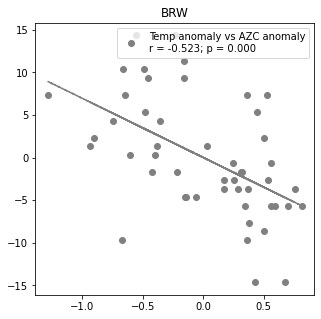

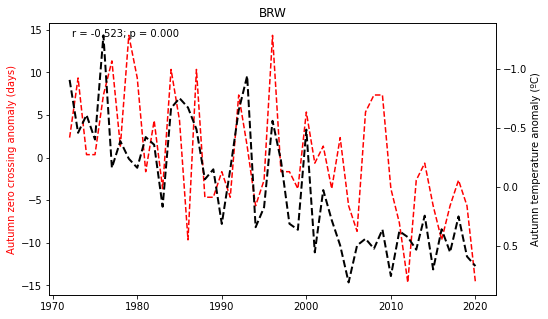

In [204]:
make_plots(station=corr_station, stations=stations, start_year=corr_start, end_year=corr_end, ccg_output=ccg_output,
    tmp_per_station=tmp_per_station, common_tmp_file=common_tmp_file, data_dir=data_dir, detrend=detrend, name=name, tx=0.05)